# ChebTools: A C++11 library for working with Chehyshev expansions
    
By Ian Bell, Bradley Alpert, and Lucas Bouck

Credits:
* The original concept for this notebook came from the paper of [Battles and Trefethen]( http://people.maths.ox.ac.uk/trefethen/publication/PDF/2004_107.pdf) and the MATLAB library [chebfun](http://www.chebfun.org)
* This notebook mirrors elements of the demonstration notebooks of the Python library [pychebfun](https://github.com/pychebfun) and the Julia library [ApproxFun](https://github.com/JuliaApproximation/ApproxFun.jl); ``ApproxFun`` was developed by members of the team behind ``chebfun``.


In [55]:
%matplotlib inline
import ChebTools as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy.special

## Construction

There are a number of different means for constructing ``ChebyshevExpansion`` objects.  The first is for the case where the coefficients of the ChebyshevExpansion are known *a priori*.  Just construct a ``ChebyshevExpansion`` object, passing the coefficients, and the minimum and maximum values for ``x`` you want to model:

In [43]:
# Here we use the canonical expansion interval of [-1,1] though other intervals are possible
# Coefficients are connected with increasing degree Chebyshev polynomial basis functions
# The degree is implicit, equal to len(c)-1
e = ct.ChebyshevExpansion([1,2,3,4], -1, 1)
# Let's get the coefficients back again to make sure we set them properly
e.coef()

array([ 1.,  2.,  3.,  4.])

Alternatively, if you have a function you want to approximate (the more useful application of Chebyshev expansions), you can pass a lambda function to the generator function.  Again, you pass the interval you want to model, along with the function, and the degree of the expansion you want to produce:

In [44]:
# This is the function we want to interpolate
# You could have used any 1-D function here
f = lambda x:np.tan(x+1/4) + np.cos(10*x**2 + np.exp(np.exp(x)))

# Generate a 60-degree expansion of f in [-1, 1]
e = ct.generate_Chebyshev_expansion(60, f, -1, 1)

You can get outputs from the expansion by calling the ``y`` function of the expansion.  Also, if you want to see where the Cheybyshev-Lobatto nodes are, you can also get that information from the expansion with the appropriate methods

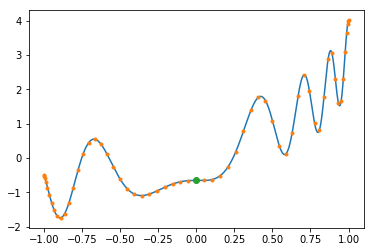

In [45]:
# Plot the function itself with high precision
xx = np.linspace(e.xmin(), e.xmax(), 1000)
plt.plot(xx, e.y(xx))

# Get the Chebyshev-Lobatto nodes in [xmin, xmax] and overlay them
plt.plot(e.get_nodes_realworld(), e.get_node_function_values(), '.')

# Plot a single value at x=0
plt.plot(0, e.y(0), 'o')

## Operations with expansions

A ``ChebyshevExpansion`` is, at its core, nothing more than a set of coefficients of the expansion.  A number of operations can be carried out on the expansions themselves that map to operations on the coefficients of the expansion:
* Multiply two expansions together
* Multiply an expansion by a constant
* Add/multiply/subtract two expansions
* Take derivative of expansion w.r.t. its independent variable
* Obtain the roots of the expansion ($f(x) = 0$)

Here are two different methods of generating an expansion of $x^3$.  Note that both have the same coefficients (to numerical precision; analytic solution is $[3/4,0,1/4,0]$):

In [46]:
cube = ct.generate_Chebyshev_expansion(3, lambda x: x**3, -1, 1)
ex = ct.generate_Chebyshev_expansion(3, lambda x: x, -1, 1)
cube2 = ex*ex*ex
print('from x^3:', cube.coef()[0:4])
print('from x*x*x', cube2.coef()[0:4])

from x^3: [  8.32667268e-17   7.50000000e-01  -5.55111512e-17   2.50000000e-01]
from x*x*x [  1.38777878e-17   7.50000000e-01  -8.32667268e-17   2.50000000e-01]


Same thing for an expansion of $\sin(5\pi x)$:

In [47]:
sin5 = ct.generate_Chebyshev_expansion(100, lambda x: np.sin(5*np.pi*x), -1, 1)
sin5.y(np.linspace(0,0.2,5))

array([  8.24779698e-16,   7.07106781e-01,   1.00000000e+00,
         7.07106781e-01,  -2.33343541e-15])

And now we add two expansions together and plot it

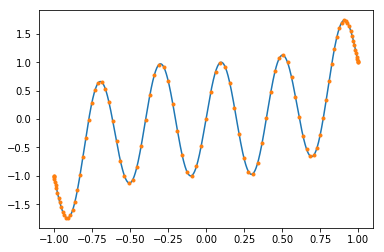

In [48]:
chebsum = cube+sin5
xx = np.linspace(chebsum.xmin(), chebsum.xmax(), 1000)
plt.plot(xx, chebsum.y(xx))
# Get the Chebyshev-Lobatto nodes in [xmin, xmax] and overlay them
plt.plot(chebsum.get_nodes_realworld(), chebsum.get_node_function_values(), '.')

Same thing for the product of two expansions

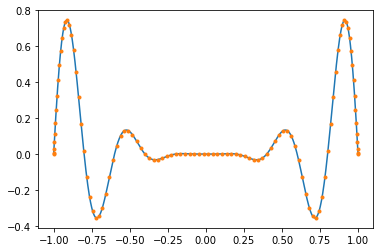

In [49]:
chebmult = cube*sin5
xx = np.linspace(chebmult.xmin(), chebmult.xmax(), 1000)
plt.plot(xx, chebmult.y(xx))
# Get the Chebyshev-Lobatto nodes in [xmin, xmax] and overlay them
plt.plot(chebmult.get_nodes_realworld(), chebmult.get_node_function_values(), '.')

### Root finding

In [52]:
%timeit chebmult.real_roots(False)

6.74 ms ± 94.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Approximation Theory

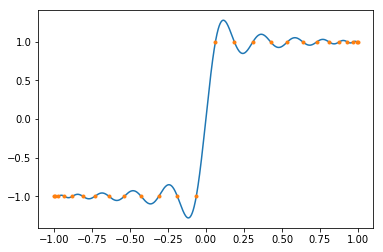

In [31]:
f_sign = ct.generate_Chebyshev_expansion(25, lambda x: np.sign(x), -1, 1)
xx = np.linspace(-1, 1, 1000)
plt.plot(xx, f_sign.y(xx))
# Get the Chebyshev-Lobatto nodes in [xmin, xmax] and overlay them
plt.plot(f_sign.get_nodes_realworld(), f_sign.get_node_function_values(), '.')

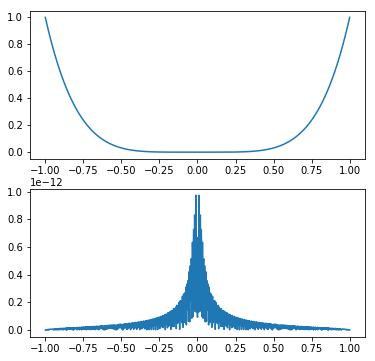

In [32]:
f = lambda x: np.abs(x)**5
f_ax5 = ct.generate_Chebyshev_expansion(428, f, -1, 1)
xx = np.linspace(-1, 1, 1000)
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))
ax1.plot(xx, f_ax5.y(xx))
ax2.plot(xx, np.abs(f(xx) - f_ax5.y(xx)))

Joining a number of these methods together, we can do a more interesting example where we find and plot the roots and extrema of the Bessel function $J_0$

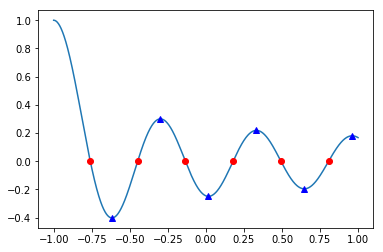

In [33]:
import scipy.special
def J_0(x):
    return scipy.special.jn(0,x)
f = ct.generate_Chebyshev_expansion(200, lambda x: J_0(10*(1+x)), -1, 1)

# Roots of the function
rts = f.real_roots(True)
# Extrema of the function (roots of the derivative, where dy/dx =0)
extrema = f.deriv(1).real_roots(True)

xx = np.linspace(f.xmin(), f.xmax(), 1000)
plt.plot(xx, f.y(xx))
plt.plot(rts, np.zeros_like(rts), 'ro')
plt.plot(extrema, f.y(extrema), 'b^')

## Integrals

## ODE 

## Boundary Value Problems